<a href="https://colab.research.google.com/github/Rachhh53/Disaster-Tweets-Kaggle/blob/main/DisasterTweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingest

In [1]:
!pip install kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [3]:
!kaggle competitions download -c nlp-getting-started

test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
from matplotlib import pyplot as plt
import math, os, re, time, random, string
import numpy as np, pandas as pd, seaborn as sns

# this is just cool
from tqdm import tqdm

# visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')   #for optimum aesthetics 
import seaborn as sns

# natural language processing
from collections import defaultdict
import wordcloud

# ignore warnings because they are annoying
import warnings
warnings.filterwarnings('ignore')

# for neural nets
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras import Input

from keras.preprocessing.sequence import pad_sequences
from keras import Input
from keras.preprocessing.text import Tokenizer

#import neural network basic
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU, GRU
from keras import Input, Model, regularizers
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [5]:
# seed for reproducable results
def seed_everything(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
seed_everything(34)

# EDA

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


There are three features in this dataset: keyword, loation and text.<br>
Target is the dependent variable

In [7]:
# save ID for final submission
test_id = test['id']

# drop from train and test
columns = {'id', 'location'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

# fill missing with unknown
train['keyword'] = train['keyword'].fillna('unknown')
test ['keyword'] = test['keyword'].fillna('unknown')

# add keyword to tweets
train['text'] = train['text'] + ' ' + train['keyword']
test['text'] = test['text'] + ' ' + test['keyword']

# drop fkeyword from train and test
columns = {'keyword'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

# combine datasets for EDA
df = train.append(test)

In [8]:
print('There are', len(train), 'rows in the train set')
print('There are', len(test), 'rows in the test set')

There are 7613 rows in the train set
There are 3263 rows in the test set


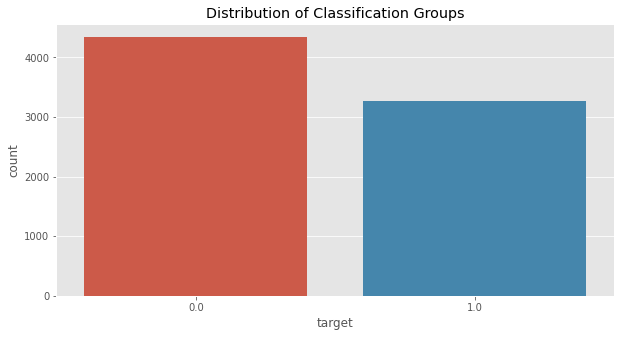

In [9]:
#set figure size
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
graph1 = sns.countplot(x = 'target', data = df)

#give title and plot
plt.title('Distribution of Classification Groups')
plt.show(graph1)

Class 0 = not a disaster tweet<br>
Class 1 = disaster tweet<br>
There is a class imbalance here

## Num Words Dist

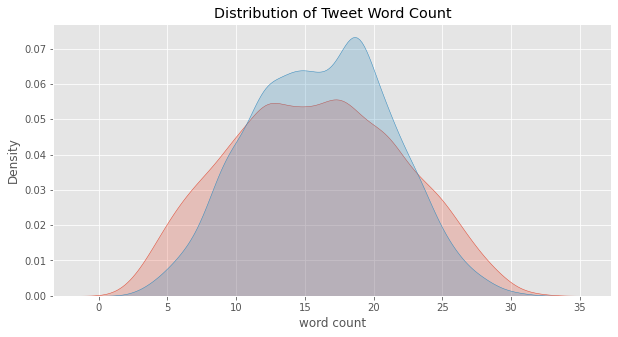

In [10]:
# create column for the number of words in tweet
df['word count'] = df['text'].apply(lambda x: len(x.split()))

# split so we can use updated train set with new feature
train = df[:len(train)]

# define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

# create graphs
sns.kdeplot(train['word count'][train['target'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(train['word count'][train['target'] == 1], shade = True, label = 'Disaster tweet')

# set title and plot
plt.title('Distribution of Tweet Word Count')
plt.show()

## Num Chars Dist

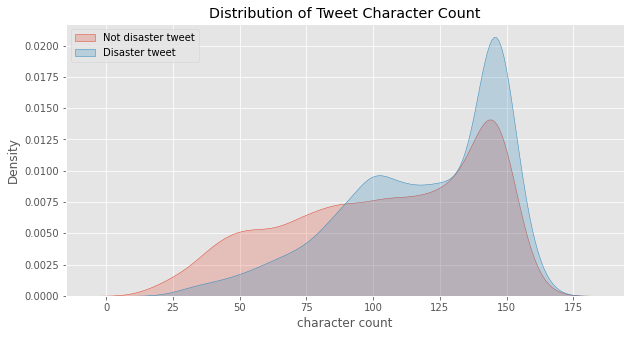

In [11]:
# create column for the number of characters in a tweet
df['character count'] = df['text'].apply(lambda x: len(x))

# split so we can use updated train set with new feature
train = df[:len(train)]

# define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

# create graphs
sns.kdeplot(train['character count'][train['target'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(train['character count'][train['target'] == 1], shade = True, label = 'Disaster tweet')

# set title and plot
plt.title('Distribution of Tweet Character Count')
plt.legend(loc='upper left')
plt.show()

The Kaggle competition doesn't tell us when the Tweets were collected, but Tweet lengths used to be limited to 140 characters and have since increased to 280 characters. It looks like this dataset was collected maybe right after that change occurred.<br>
Most Tweets in this dataset are right around 130 characters.

## Ave word length

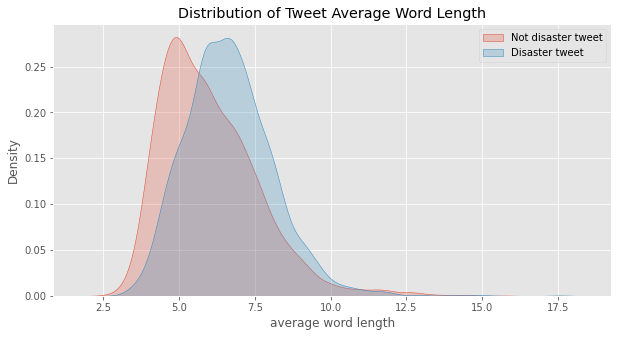

In [12]:
# define function to find average word length 
def average_word_length(x):
    x = x.split()
    return np.mean([len(i) for i in x])

# broadcast to text column
df['average word length'] = df['text'].apply(average_word_length)

# split so we can use updated train set with new feature
train = df[:len(train)]

# define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

# create graphs
sns.kdeplot(train['average word length'][train['target'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(train['average word length'][train['target'] == 1], shade = True, label = 'Disaster tweet')

# set title
plt.title('Distribution of Tweet Average Word Length')

# plot graphs
plt.legend(loc='upper right')
plt.show()

The average word length in class = 0 is slightly longer than the average word length of the class = 1

## Additional features

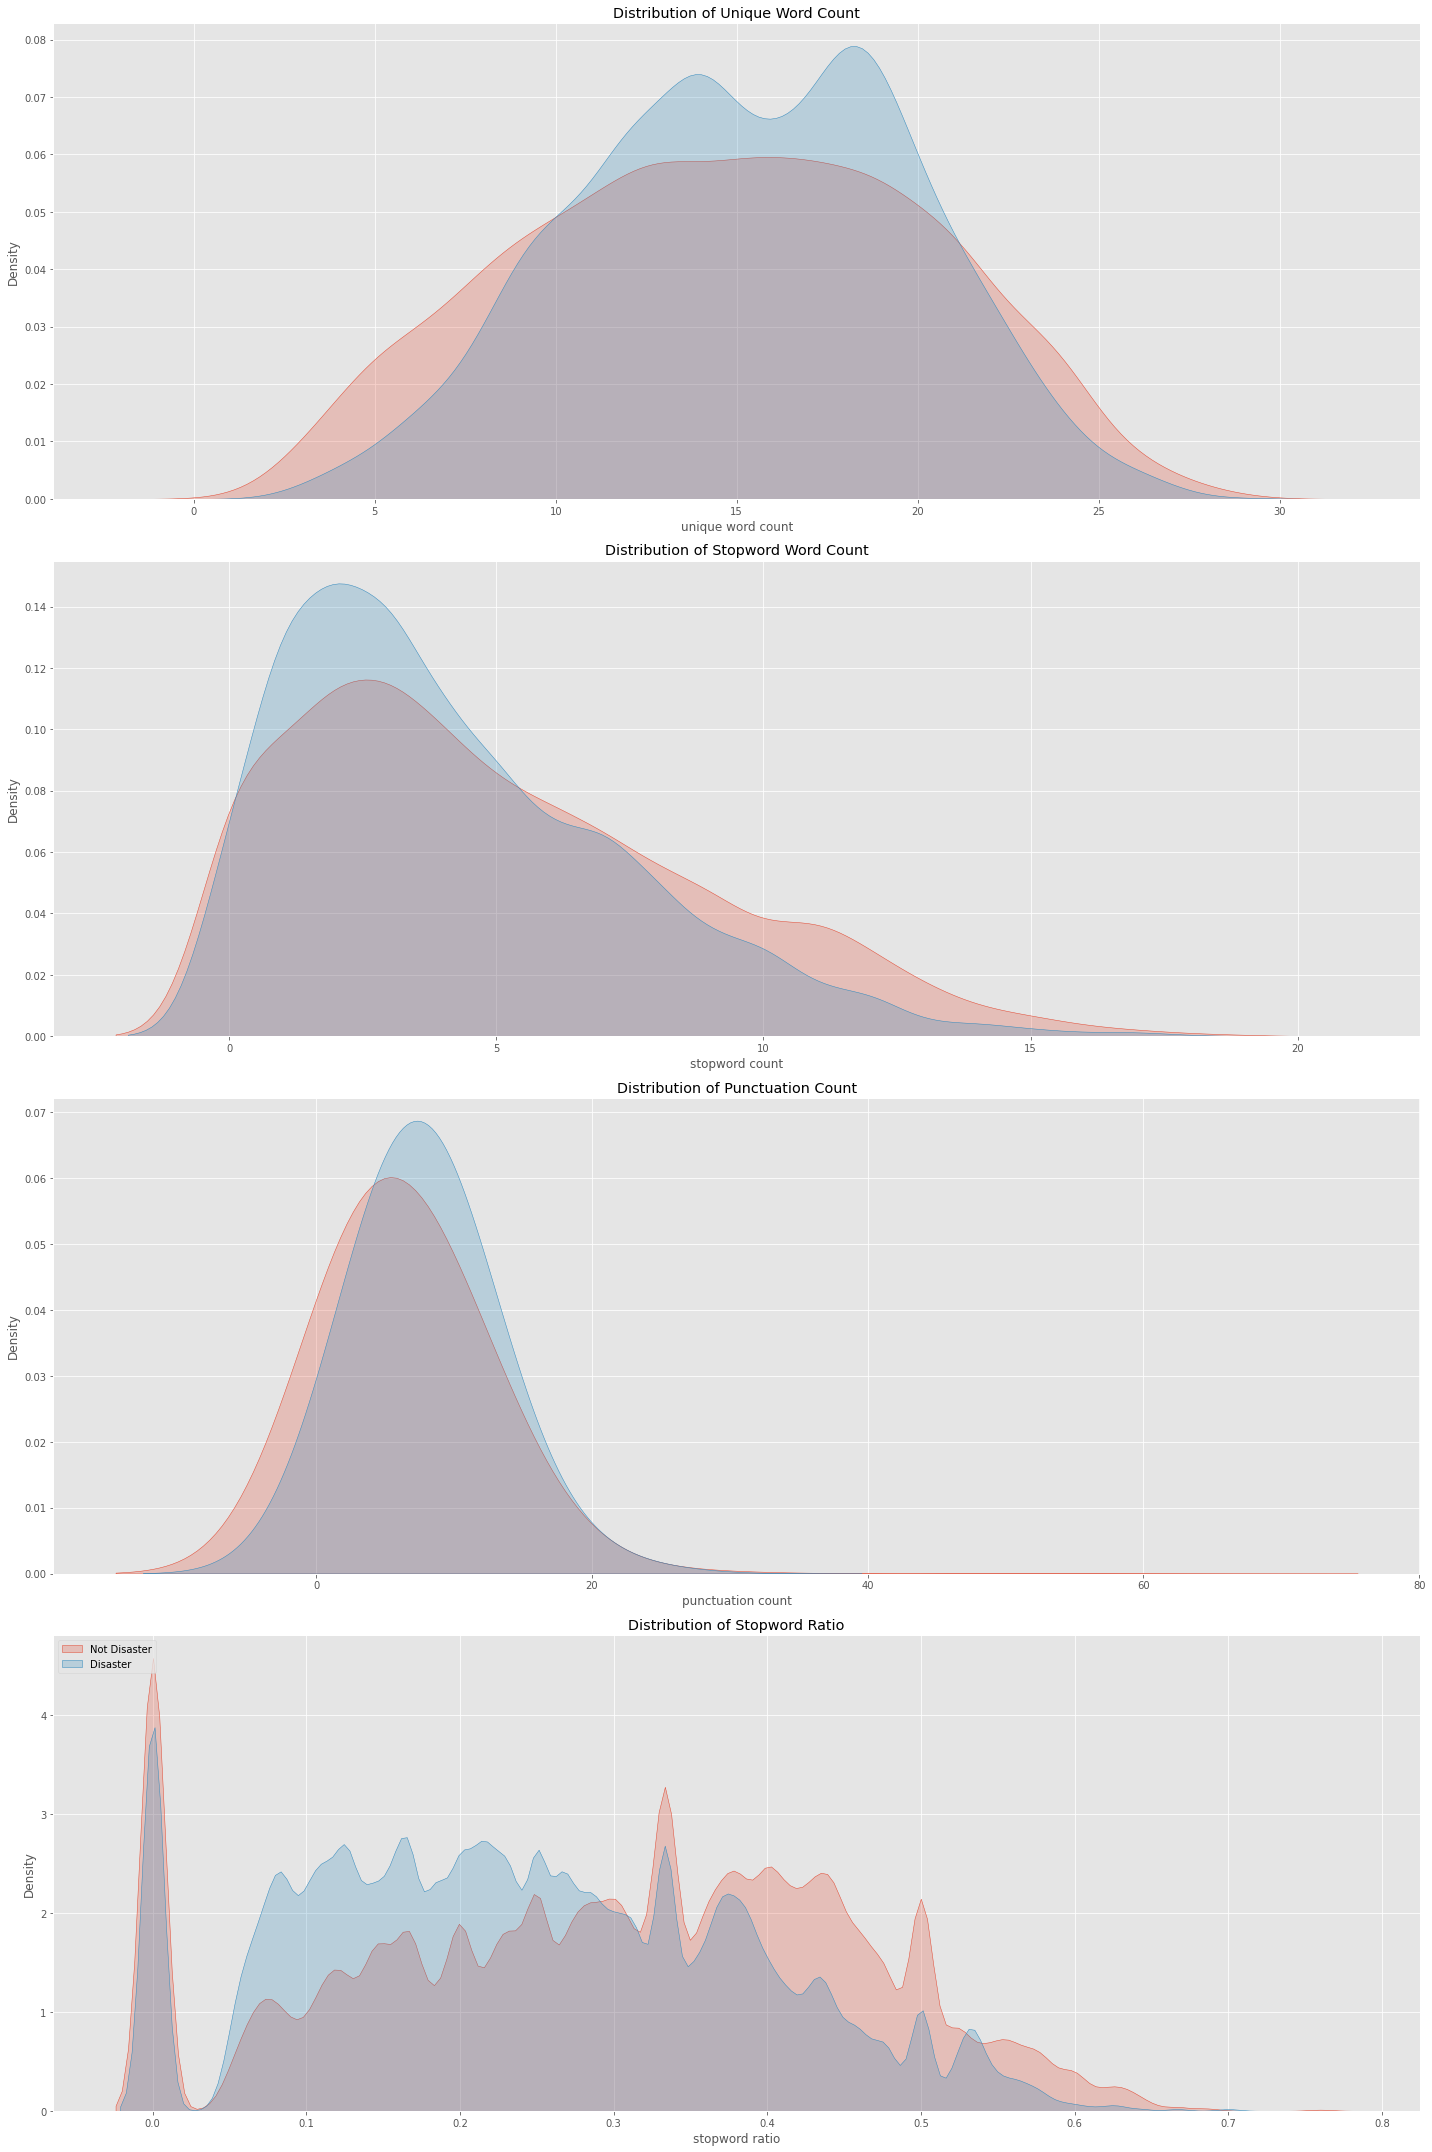

In [13]:
# add unique word count
df['unique word count'] = df['text'].apply(lambda x: len(set(x.split())))

# add stopword count
df['stopword count'] = df['text'].apply(lambda x: len([i for i in x.lower().split() if i in wordcloud.STOPWORDS]))

# add stopword ratio
df['stopword ratio'] = df['stopword count'] / df['word count']

# add punctuation count
df['punctuation count'] = df['text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))

# split so we can use updated train set
train = df[:len(train)]

disaster = train['target'] == 1

# produce graphs to visualize newly added features
fig, axes = plt.subplots(4, figsize=(20, 30))

graph1 = sns.kdeplot(train.loc[~disaster]['unique word count'], shade = True, label = 'Not Disaster', ax=axes[0])
graph1 = sns.kdeplot(train.loc[disaster]['unique word count'], shade = True, label = 'Disaster', ax=axes[0])
graph1.set_title('Distribution of Unique Word Count')

graph2 = sns.kdeplot(train.loc[~disaster]['stopword count'], shade = True, label = 'Not Disaster', ax=axes[1])
graph2 = sns.kdeplot(train.loc[disaster]['stopword count'], shade = True, label = 'Disaster', ax=axes[1])
graph2.set_title('Distribution of Stopword Word Count')

graph3 = sns.kdeplot(train.loc[~disaster]['punctuation count'], shade = True, label = 'Not Disaster', ax=axes[2], bw = 1)
graph3 = sns.kdeplot(train.loc[disaster]['punctuation count'], shade = True, label = 'Disaster', ax=axes[2], bw = 1)
graph3.set_title('Distribution of Punctuation Count')

graph4 = sns.kdeplot(train.loc[~disaster]['stopword ratio'], shade = True, label = 'Not Disaster', ax=axes[3], bw = .05)
graph4 = sns.kdeplot(train.loc[disaster]['stopword ratio'], shade = True, label = 'Disaster', ax=axes[3], bw = .05)
graph4.set_title('Distribution of Stopword Ratio')

fig.tight_layout()
plt.legend(loc='upper left')
plt.show()

## Cleaning

Keras's Tokenize object, which automatically converts all words to lowercase and filters out punctuation<br>

In [14]:
# remove punctuation
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

# remove stopwords
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in wordcloud.STOPWORDS])

# remove words less than 4 
def remove_less_than(x):
    return ' '.join([i for i in x.split() if len(i) > 3])

# remove words with non-alphabet characters
def remove_non_alphabet(x):
    return ' '.join([i for i in x.split() if i.isalpha()])

def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

Confirm operation

In [15]:
# check strip_all_entities functionality
strip_all_entities('@shawn Titanic #tragedy could have been prevented Economic \
                   Times: Telegraph.co.ukTitanic tragedy could have been preve... http://bet.ly/tuN2wx')

'Titanic tragedy could have been prevented Economic Times Telegraph co ukTitanic tragedy could have been preve'

In [16]:
PROCESS_TWEETS = False
if PROCESS_TWEETS:
    # apply all of above functions
    df['text'] = df['text'].apply(lambda x: x.lower())
    df['text'] = df['text'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x, flags = re.MULTILINE))
    df['text'] = df['text'].apply(remove_punctuation)
    df['text'] = df['text'].apply(remove_stopwords)
    df['text'] = df['text'].apply(remove_less_than)
    df['text'] = df['text'].apply(remove_non_alphabet)

In [17]:
# take care of contractions so we don't lose them when we tokenize
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}


contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)
# testing
expand_contractions("can't stop won't stop")

'cannot stop will not stop'

In [18]:
#apply to whole text column
df['text'] = df['text'].apply(expand_contractions)

In [19]:
df.head

<bound method NDFrame.head of                                                    text  target  word count  \
0     Our Deeds are the Reason of this #earthquake M...     1.0          14   
1        Forest fire near La Ronge Sask. Canada unknown     1.0           8   
2     All residents asked to 'shelter in place' are ...     1.0          23   
3     13,000 people receive #wildfires evacuation or...     1.0           9   
4     Just got sent this photo from Ruby #Alaska as ...     1.0          17   
...                                                 ...     ...         ...   
3258  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...     NaN           9   
3259  Storm in RI worse than last hurricane. My city...     NaN          24   
3260  Green Line derailment in Chicago http://t.co/U...     NaN           7   
3261  MEG issues Hazardous Weather Outlook (HWO) htt...     NaN           8   
3262  #CityofCalgary has activated its Municipal Eme...     NaN           9   

      character count

Someone on Kaggle was kind enough to go through this dataset and try to catch hastags, usernames, correct slang, and spell check (they actually have another spell check step that I didn't use because that seems hinky - culture and all).

In [20]:
# this text correction step was brought to you by this kaggle notebook:
# https://www.kaggle.com/tuckerarrants/disaster-tweets-eda-glove-rnns-bert
def clean(tweet):

    #correct some acronyms while we are at it
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)      
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet) 
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)  
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)  
    tweet = re.sub(r"amirite", "am I right", tweet)
    
    #and some typos/abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    #hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)

    return tweet

df['text'] = df['text'].apply(clean)

## Split our test and training set

In [21]:
tweets = [tweet for tweet in df['text']]

#split data to update changes
train = df[:len(train)]
test = df[len(train):]

## N-Gram Analysis

In [22]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in wordcloud.STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

# Unigrams

disaster_unigrams = defaultdict(int)
for word in df[train['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 1):
        disaster_unigrams[word] += 1
disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])

nondisaster_unigrams = defaultdict(int)
for word in df[train['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 1):
        nondisaster_unigrams[word] += 1
nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams

disaster_bigrams = defaultdict(int)
for word in df[train['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 2):
        disaster_bigrams[word] += 1
disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])

nondisaster_bigrams = defaultdict(int)
for word in df[train['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 2):
        nondisaster_bigrams[word] += 1
nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams

disaster_trigrams = defaultdict(int)
for word in df[train['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 3):
        disaster_trigrams[word] += 1
disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])

nondisaster_trigrams = defaultdict(int)
for word in df[train['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 3):
        nondisaster_trigrams[word] += 1
nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

# 4-grams

disaster_4grams = defaultdict(int)
for word in df[train['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 4):
        disaster_4grams[word] += 1
disaster_4grams = pd.DataFrame(sorted(disaster_4grams.items(), key=lambda x: x[1])[::-1])

nondisaster_4grams = defaultdict(int)
for word in df[train['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 4):
        nondisaster_4grams[word] += 1
nondisaster_4grams = pd.DataFrame(sorted(nondisaster_4grams.items(), key=lambda x: x[1])[::-1])

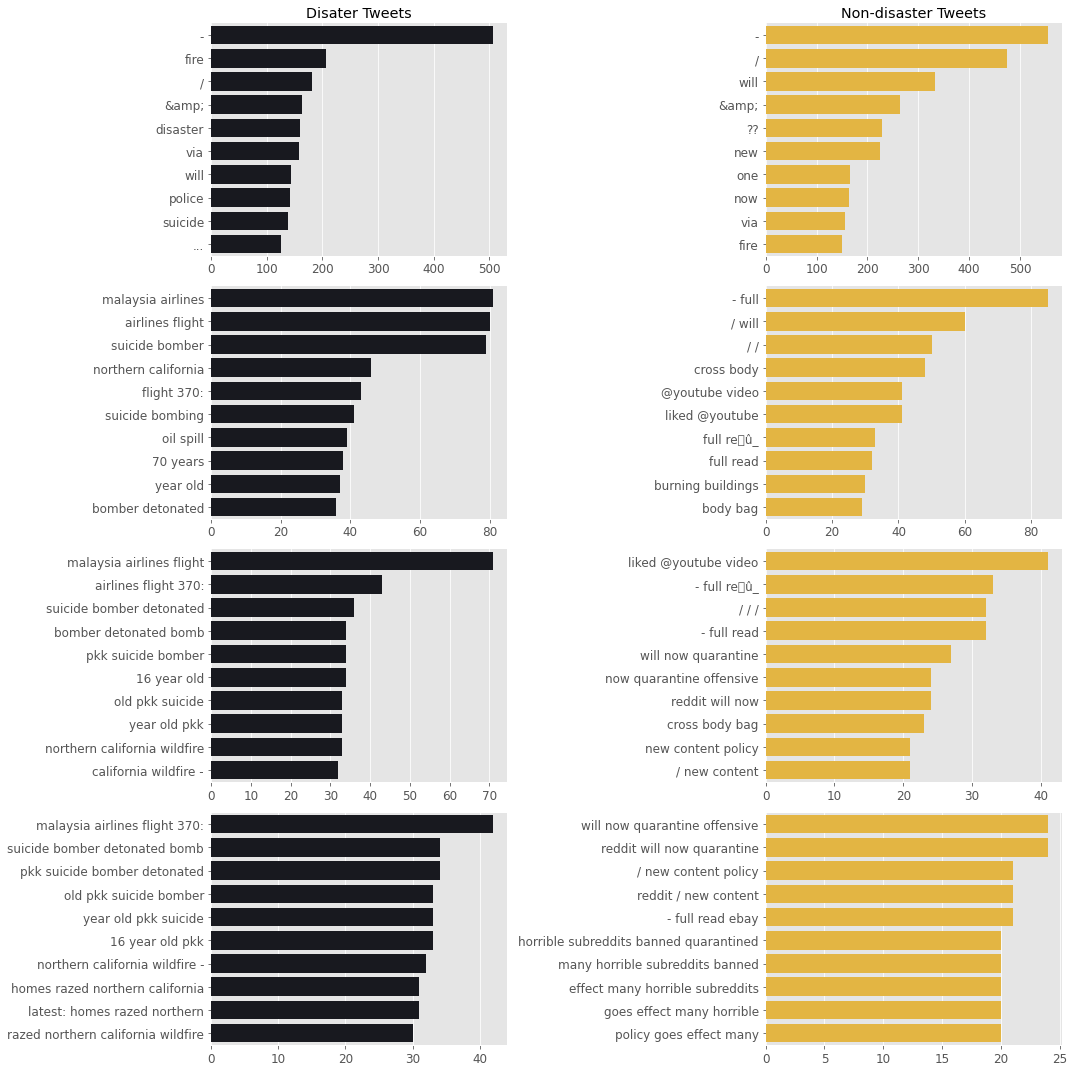

In [23]:
N = 10

fig, ax = plt.subplots(4, 2, figsize = (15, 15))
plt.tight_layout()

sns.barplot(y = disaster_unigrams[0].values[:N], x = disaster_unigrams[1].values[:N], ax = ax[0, 0], color='#171820').set(title='Disater Tweets')
sns.barplot(y = nondisaster_unigrams[0].values[:N], x = nondisaster_unigrams[1].values[:N], ax = ax[0, 1], color = '#fdc029').set(title='Non-disaster Tweets') # yellow

sns.barplot(y = disaster_bigrams[0].values[:N], x = disaster_bigrams[1].values[:N], ax = ax[1, 0], color='#171820')
sns.barplot(y = nondisaster_bigrams[0].values[:N], x = nondisaster_bigrams[1].values[:N], ax = ax[1, 1], color = '#fdc029')

sns.barplot(y = disaster_trigrams[0].values[:N], x = disaster_trigrams[1].values[:N], ax = ax[2, 0], color='#171820')
sns.barplot(y = nondisaster_trigrams[0].values[:N], x = nondisaster_trigrams[1].values[:N], ax = ax[2, 1], color = '#fdc029')

sns.barplot(y = disaster_4grams[0].values[:N], x = disaster_4grams[1].values[:N], ax = ax[3, 0], color='#171820')
sns.barplot(y = nondisaster_4grams[0].values[:N], x = nondisaster_4grams[1].values[:N], ax = ax[3, 1], color = '#fdc029')

for i in range(0, 4):
    for j in range(0, 2):
        ax[i, j].spines['right'].set_visible(False)
        ax[i, j].spines['left'].set_visible(False)
        ax[i, j].spines['top'].set_visible(False)
        ax[i, j].set_xlabel('')
        ax[i, j].set_ylabel('')
        ax[i, j].tick_params(axis='x', labelsize=12)
        ax[i, j].tick_params(axis='y', labelsize=12)
    

plt.tight_layout()
plt.show()

# Modeling

## Word Embeddings

In [24]:
from keras.preprocessing.text import Tokenizer

#find way to tokenize punctuation
to_exclude = '*+-/()%\n[\\]{|}^_`~\t'
to_tokenize = '!"#$&?:;<=>@'
tokenizer = Tokenizer(filters = to_exclude)
text = 'Why are you so f%#@ing angry all the time?!'
text = re.sub(r'(['+to_tokenize+'])', r' \1 ', text)
tokenizer.fit_on_texts([text])

#view new text
print(tokenizer.word_index)

{'why': 1, 'are': 2, 'you': 3, 'so': 4, 'f': 5, '#': 6, '@': 7, 'ing': 8, 'angry': 9, 'all': 10, 'the': 11, 'time': 12, '?': 13, '!': 14}


In [25]:
# define tokenizer options
tokenizer = Tokenizer()
# tokenizer = Tokenizer(oov_token = '<OOV>')           #if you wanted to tokenized OOV words
# tokenizer = Tokenizer(filters = to_exclude)          #if you wanted to include punctuation
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences)
labels = train['target']
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

nlp_train = data[:len(train)]
labels = labels
nlp_test = data[len(train):]

MAX_SEQUENCE_LENGTH = data.shape[1]

Found 29279 unique tokens.
Shape of data tensor: (10876, 40)
Shape of label tensor: (7613,)


One-Hot Encoding -  GloVe

"GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space."

In [26]:
# get GloVe zip
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-03-05 23:23:21--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-05 23:23:21--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-05 23:23:21--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [27]:
# unzip GloVe
!unzip glove*.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: [n]
error:  invalid response [[n]]
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.300d.txt       


In [28]:
# get GloVe vector embeddings
embeddings_index = {}
# this is the Wikipedia 2014 + Gigaword 5 dataset
# https://nlp.stanford.edu/projects/glove/
with open('glove.6B.200d.txt','r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

print('Found %s word vectors in the GloVe library' % len(embeddings_index))

400000it [00:19, 20187.37it/s]

Found 400000 word vectors in the GloVe library


In [29]:
EMBEDDING_DIM = 200   #defined by size of GloVe word vector dimensions

In [33]:
#initialize embedding matrix with zeros
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

#add glove word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print("Our embedded matrix is of dimension", embedding_matrix.shape)

100%|██████████| 29279/29279 [00:00<00:00, 315980.08it/s]

Our embedded matrix is of dimension (29280, 200)


In [31]:
embedding = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix],
                     input_length = MAX_SEQUENCE_LENGTH, trainable = False)  

# we do not want embedding layer to train since it has been pretrained

Pass our NLP data through an LSTM layer and add the scaled features we created above to the input before the final layer

In [34]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def scale(df, scaler):
    return scaler.fit_transform(df.iloc[:, 2:])

# and scale
#nlp_train2 = scale(nlp_train, StandardScaler())
meta_train = scale(train, StandardScaler())
meta_test = scale(test, StandardScaler())

## LSTM

In [35]:
# function to create lstm model
def create_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    # define activation
    activation = LeakyReLU(alpha = 0.01)
    
    # define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    # add LSTM layer
    if bidirectional:
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')))(emb)
    else:
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal'))(emb)        
     
    # add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    # add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    # compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [36]:
# define conveient training function to visualize learning curves
def plot_learning_curves(history): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper left')

    fig.suptitle("Model Accuracy", fontsize=14)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

In [37]:
# create our first model
lstm = create_lstm(spatial_dropout = .2, dropout = .2, recurrent_dropout = .2,
                     learning_rate = 3e-4, bidirectional = True)
lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 nlp_input (InputLayer)         [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 200)      5856000     ['nlp_input[0][0]']              
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 40, 200)     0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 200)          240800      ['spatial_dropout1d[0][0]']  

What the model expects

In [39]:
[print(i.shape, i.dtype) for i in lstm.inputs]
print("-----")
[print(o.shape, o.dtype) for o in lstm.outputs]
print("-----")
[print(l.name, l.input_shape, l.dtype) for l in lstm.layers]

(None, 40) <dtype: 'float32'>
(None, 7) <dtype: 'float32'>
-----
(None, 1) <dtype: 'float32'>
-----
nlp_input [(None, 40)] float32
embedding (None, 40) float32
spatial_dropout1d (None, 40, 200) float32
bidirectional (None, 40, 200) float32
meta_train [(None, 7)] float32
concatenate [(None, 200), (None, 7)] float32
dropout (None, 207) float32
dense (None, 207) float32


[None, None, None, None, None, None, None, None]

In [40]:
nlp_train

array([[    0,     0,     0, ...,    96,    47,   361],
       [    0,     0,     0, ...,  8766,  1472,   361],
       [    0,     0,     0, ...,    21,  1295,   361],
       ...,
       [    0,     0,     0, ...,     2,  8394,   361],
       [    0,     0,     0, ...,  2078,   190,   361],
       [    0,     0,     0, ...,     2, 23008,   361]], dtype=int32)

In [41]:
train

,text,target,word count,character count,average word length,unique word count,stopword count,stopword ratio,punctuation count
0,Our Deeds are the Reason of this #earthquake M...,1.0,14,77,4.571429,14,6,0.428571,1
1,Forest fire near La Ronge Sask. Canada unknown,1.0,8,46,4.875000,8,0,0.000000,1
2,All residents asked to 'shelter in place' are ...,1.0,23,141,5.173913,21,11,0.478261,3
3,"13,000 people receive #wildfires evacuation or...",1.0,9,73,7.111111,9,1,0.111111,2
4,Just got sent this photo from Ruby #Alaska as ...,1.0,17,96,4.647059,16,7,0.411765,2
...,...,...,...,...,...,...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1.0,12,91,6.666667,12,2,0.166667,5
7609,@aria_ahrary @TheTawniest The out of control w...,1.0,21,133,5.380952,18,9,0.428571,5
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1.0,9,73,7.222222,9,1,0.111111,11
7611,Police investigating after an e-bike collided ...,1.0,20,145,6.300000,20,5,0.250000,5


Implement early stopping to reduce overfitting

In [45]:
# define early stopping callback
callback = EarlyStopping(monitor = 'val_loss', patience = 4)

# include it in your models training
history = lstm.fit([nlp_train, meta_train], labels, validation_split = .2, epochs = 100, callbacks = [callback])

Epoch 1/100
191/191 [==============================] - 44s 209ms/step - loss: 0.4139 - accuracy: 0.8202 - val_loss: 0.3981 - val_accuracy: 0.8306
Epoch 2/100
191/191 [==============================] - 40s 208ms/step - loss: 0.4037 - accuracy: 0.8286 - val_loss: 0.3997 - val_accuracy: 0.8280
Epoch 3/100
191/191 [==============================] - 39s 207ms/step - loss: 0.3997 - accuracy: 0.8299 - val_loss: 0.4059 - val_accuracy: 0.8214
Epoch 4/100
191/191 [==============================] - 40s 209ms/step - loss: 0.3935 - accuracy: 0.8325 - val_loss: 0.4000 - val_accuracy: 0.8194
Epoch 5/100
191/191 [==============================] - 40s 209ms/step - loss: 0.3889 - accuracy: 0.8315 - val_loss: 0.4015 - val_accuracy: 0.8181


We selected to monitor val_loss here because we are focused on not overfitting.<br>
val_accuracy would stop when the accuracy started to decrease.<br>
The patience param is the number of epochs that will run before stopping once the monitored parameter has been optimized.<br>

In [42]:
# fit model
# 5 epochs is what early stopping told us is optimal to reduce loss so that's what we'll go with
history1 = lstm.fit([nlp_train, meta_train], labels, validation_split = .2, epochs = 5, batch_size = 21, verbose = 1)

Epoch 1/5
290/290 [==============================] - 53s 165ms/step - loss: 0.5228 - accuracy: 0.7386 - val_loss: 0.4313 - val_accuracy: 0.8017
Epoch 2/5
290/290 [==============================] - 46s 160ms/step - loss: 0.4511 - accuracy: 0.8030 - val_loss: 0.4085 - val_accuracy: 0.8201
Epoch 3/5
290/290 [==============================] - 47s 161ms/step - loss: 0.4413 - accuracy: 0.8061 - val_loss: 0.4102 - val_accuracy: 0.8122
Epoch 4/5
290/290 [==============================] - 51s 177ms/step - loss: 0.4319 - accuracy: 0.8074 - val_loss: 0.4050 - val_accuracy: 0.8181
Epoch 5/5
290/290 [==============================] - 47s 163ms/step - loss: 0.4177 - accuracy: 0.8190 - val_loss: 0.4018 - val_accuracy: 0.8207


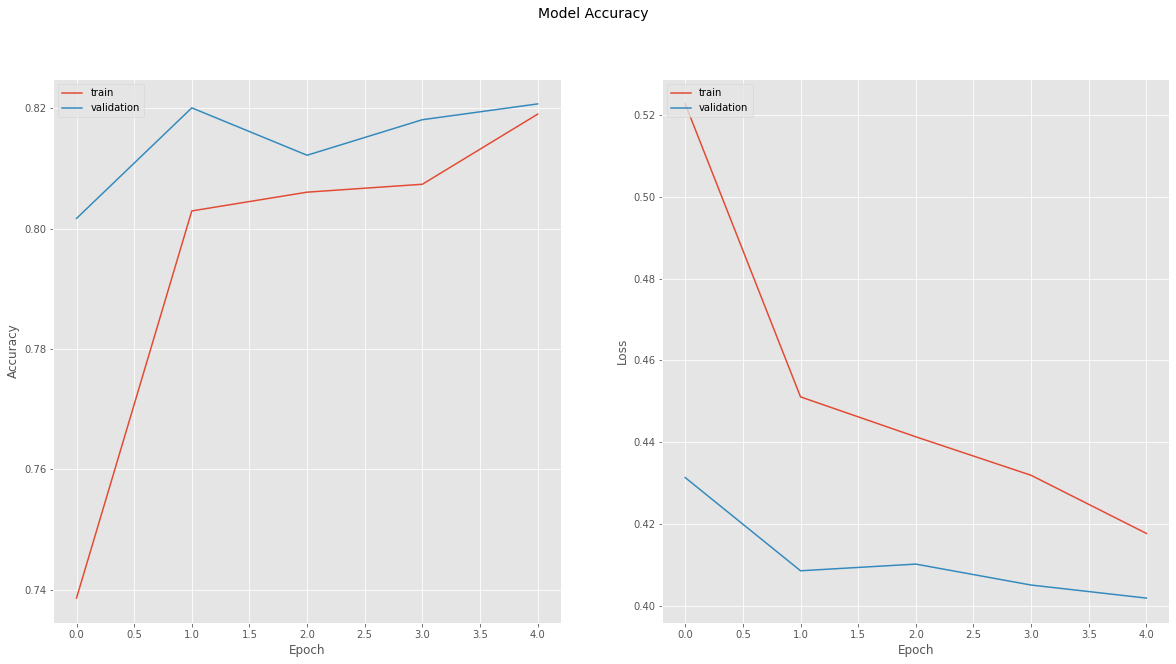

In [43]:
# view model 1 learning curves
plot_learning_curves(history1)

82.07% final accuracy - pretty good!

## Hidden Layers/LeakyReLu

* Trying to improve performace with more layers
* Leaky ReLu allows the model to remember information about the negative values

In [46]:
# function to create lstm model
def create_lstm_2(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    #define activation
    activation = LeakyReLU(alpha = 0.01)
    
    # define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    #add LSTM layer
    if bidirectional:
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                kernel_initializer = 'orthogonal')))(emb)
    else:
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                      kernel_initializer = 'orthogonal'))(emb)
     
    # add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    # add second hidden layer
    x = Dropout(dropout)(x)
    x = (Dense(100, activation = activation, kernel_regularizer = regularizers.l2(1e-4),
              kernel_initializer = 'he_normal'))(x)
    
    # add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    # compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [47]:
# define new model
lstm_2 = create_lstm_2(spatial_dropout = .4, dropout = .4, recurrent_dropout = .4,
                       learning_rate = 3e-4, bidirectional = True)

lstm_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 nlp_input (InputLayer)         [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 200)      5856000     ['nlp_input[0][0]']              
                                                                                                  
 spatial_dropout1d_1 (SpatialDr  (None, 40, 200)     0           ['embedding[1][0]']              
 opout1D)                                                                                         
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 200)         240800      ['spatial_dropout1d_1[0][0]

In [48]:
# fit model
history2 = lstm_2.fit([nlp_train, meta_train], labels, validation_split = .2,
                       epochs = 30, batch_size = 21, verbose = 1)

Epoch 1/30
290/290 [==============================] - 54s 171ms/step - loss: 0.6035 - accuracy: 0.6901 - val_loss: 0.4719 - val_accuracy: 0.7951
Epoch 2/30
290/290 [==============================] - 48s 166ms/step - loss: 0.5247 - accuracy: 0.7642 - val_loss: 0.4479 - val_accuracy: 0.8043
Epoch 3/30
290/290 [==============================] - 48s 167ms/step - loss: 0.5042 - accuracy: 0.7749 - val_loss: 0.4518 - val_accuracy: 0.7984
Epoch 4/30
290/290 [==============================] - 48s 166ms/step - loss: 0.4984 - accuracy: 0.7803 - val_loss: 0.4423 - val_accuracy: 0.8070
Epoch 5/30
290/290 [==============================] - 49s 170ms/step - loss: 0.4858 - accuracy: 0.7854 - val_loss: 0.4376 - val_accuracy: 0.8076
Epoch 6/30
290/290 [==============================] - 49s 169ms/step - loss: 0.4838 - accuracy: 0.7890 - val_loss: 0.4574 - val_accuracy: 0.8050
Epoch 7/30
290/290 [==============================] - 49s 168ms/step - loss: 0.4733 - accuracy: 0.7938 - val_loss: 0.4341 - val_ac

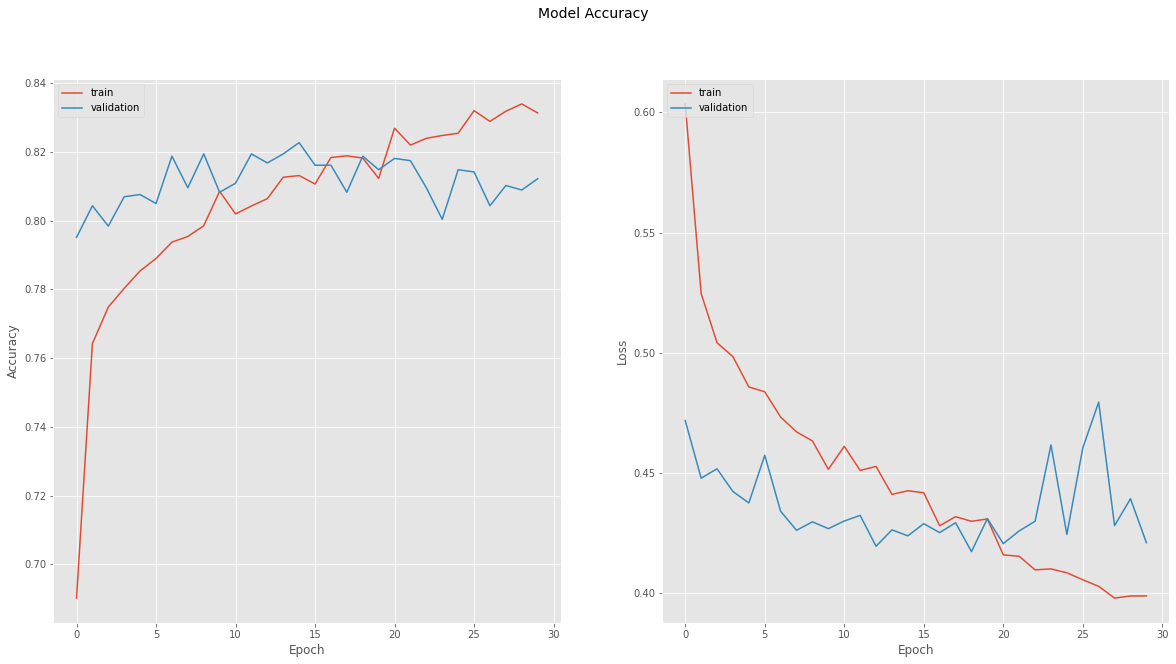

In [49]:
plot_learning_curves(history2)

These got a little crazy, but it doesn't look like this model is overfitting. 81.22% final accurcy

## Dual LSTM Layers

In [61]:
# function to create dual lstm model
def create_dual_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    # define activation
    activation = LeakyReLU(alpha = 0.01)
    
    # define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    #add dual LSTM layers
    if bidirectional:
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal', return_sequences = True)))(emb)
        nlp_out = SpatialDropout1D(dropout)(nlp_out)
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')))(emb)
    else:
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal', return_sequences = True))(emb)
        nlp_out = SpatialDropout1D(dropout)(nlp_out)
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal'))(emb)
     
     
    # add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    # add second hidden layer
    # x = Dropout(dropout)(x)
    # x = (Dense(100, activation = activation, kernel_regularizer = regularizers.l2(1e-4),
              #kernel_initializer = 'he_normal'))(x)
    
    # add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    # compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [62]:
# define new model
dual_lstm = create_dual_lstm(spatial_dropout = .4, dropout = .4, recurrent_dropout = .4,
                       learning_rate = 3e-4, bidirectional = True)

dual_lstm.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 nlp_input (InputLayer)         [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 200)      5856000     ['nlp_input[0][0]']              
                                                                                                  
 spatial_dropout1d_2 (SpatialDr  (None, 40, 200)     0           ['embedding[2][0]']              
 opout1D)                                                                                         
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 200)         240800      ['spatial_dropout1d_2[0][0]

In [63]:
history3 = dual_lstm.fit([nlp_train, meta_train], labels, validation_split = .2,
         epochs = 25, batch_size = 21, verbose = 1, callbacks = [callback])

Epoch 1/25
290/290 [==============================] - 52s 166ms/step - loss: 0.5695 - accuracy: 0.7020 - val_loss: 0.4662 - val_accuracy: 0.7787
Epoch 2/25
290/290 [==============================] - 47s 162ms/step - loss: 0.4929 - accuracy: 0.7760 - val_loss: 0.4264 - val_accuracy: 0.8076
Epoch 3/25
290/290 [==============================] - 47s 161ms/step - loss: 0.4764 - accuracy: 0.7818 - val_loss: 0.4289 - val_accuracy: 0.7997
Epoch 4/25
290/290 [==============================] - 47s 161ms/step - loss: 0.4680 - accuracy: 0.7885 - val_loss: 0.4127 - val_accuracy: 0.8148
Epoch 5/25
290/290 [==============================] - 47s 162ms/step - loss: 0.4587 - accuracy: 0.7939 - val_loss: 0.4142 - val_accuracy: 0.8096
Epoch 6/25
290/290 [==============================] - 47s 163ms/step - loss: 0.4575 - accuracy: 0.7938 - val_loss: 0.4272 - val_accuracy: 0.8096
Epoch 7/25
290/290 [==============================] - 47s 162ms/step - loss: 0.4507 - accuracy: 0.7952 - val_loss: 0.4116 - val_ac

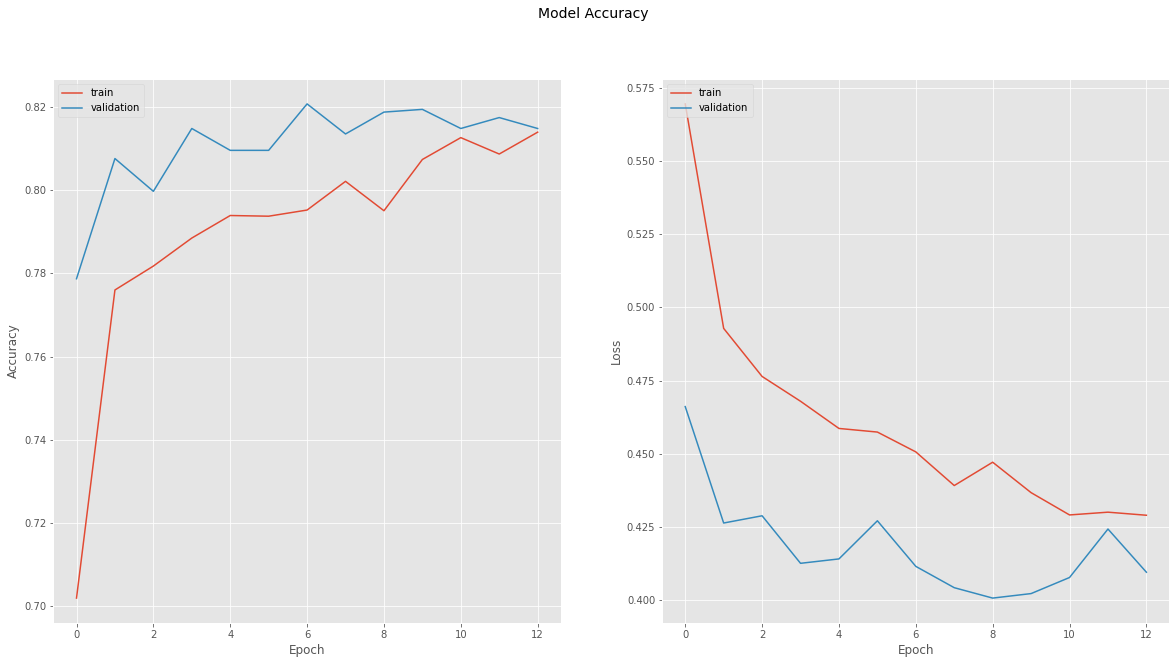

In [64]:
plot_learning_curves(history3)

81.48% accuracy sounds pretty good.

# Conclusions

## Create Submission

All the models perfomed pretty similarly. This was my first attempt at implementing early stopping and now I'll never go back. Using the pre-trained GloVe vectors, I think, helped speed up model training tremendously.

### LSTM

In [57]:
# create submission for complex lstm model
submission_lstm = pd.DataFrame()
submission_lstm['id'] = test_id
submission_lstm['prob'] = lstm.predict([nlp_test, meta_test])
submission_lstm['target'] = submission_lstm['prob'].apply(lambda x: 0 if x < .5 else 1)
submission_lstm.head(10)

,id,prob,target
0,0,0.353422,0
1,2,0.787749,1
2,3,0.896086,1
3,9,0.587916,1
4,11,0.979450,1
5,12,0.431691,0
6,21,0.139148,0
7,22,0.050436,0
8,27,0.052846,0
9,29,0.064528,0


In [58]:
submission_lstm = submission_lstm.drop('prob', 1)
submission_lstm.head(10)

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
5,12,0
6,21,0
7,22,0
8,27,0
9,29,0


In [60]:
submission_lstm.to_csv("submission.csv", index=False)

Score = .80478